# Solar Panel Performance (Part 2)

## Introduction

In a previous blog post (https://coolum001.github.io/solar.html), I looked at the long term efficiency of my solar panels (over almost ten year of operation).  Using Time Series Analysis libraries, I concluded there was a very small long-term decline in efficiency, but ended by saying that maybe climate change had played a role.

Then I realized that (courtesy of the Queensland Government) it is possible to get :

    Solar radiation - total incoming downward shortwave radiation on a horizontal surface (MJ/m2)
    
from https://www.longpaddock.qld.gov.au/silo/point-data/#responseTab2.    

I learnt a few things about Pandas wrangling in the process, mainly in the area of lining up time-series to compare them.

--------------------
## Environment

Import packages and libraries we need.

In [245]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.formula.api import ols

import pathlib

In [246]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [247]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


-----------------------
## Solar radiation data  load and explorationa 

I specified ```logpaddock``` grid point nearest to me (a distance of under 1K shouldn't make much difference to solar radiation), and downloaded a CSV file.

In [248]:
data_dir = pathlib.Path('../data/')

file1 = 'LongPaddockSolar.csv'

data_path = data_dir / file1

Read the CSV file into pandas.

In [249]:
solar = pd.read_csv(
    data_path,
    header=0,
    usecols=[2, 4],
    parse_dates={'PDate': [0]},
    dayfirst=True,
)

Explore the data, and the data types

In [250]:
solar.head()

,PDate,Solar
0,2015-01-01,28.5
1,2015-01-02,22.6
2,2015-01-03,10.7
3,2015-01-04,29.9
4,2015-01-05,18.7


In [251]:
solar.dtypes

PDate     datetime64[ns]
Solar            float64
dtype: object

In [252]:
solar.columns

Index(['PDate', 'Solar '], dtype='object')

We note that one of the column names has a pesky trailing space, so get rid of it.

In [253]:
solar.rename(
    columns={'Solar ': 'Solar'},
    inplace=True,
)

In [254]:
solar.columns

Index(['PDate', 'Solar'], dtype='object')

## Visualization
Do a quick and easy pandas plot.  As with my energy generated graphics, there are very low dips due to cloudy days.

<AxesSubplot:xlabel='PDate'>

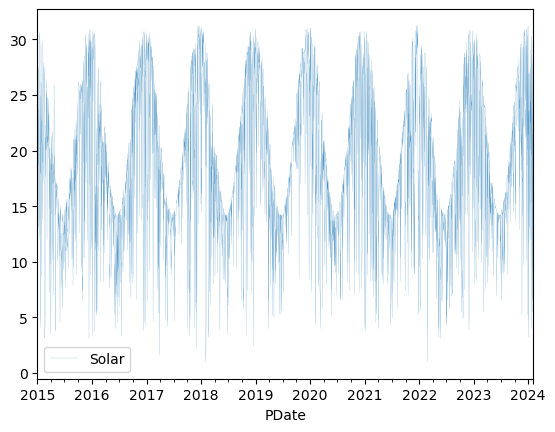

In [255]:
solar.plot(
    'PDate',
    'Solar',
    linewidth=0.1,
)

Check the date range of this dataset.

In [256]:
solar.head(1), solar.tail(1)

(       PDate  Solar
 0 2015-01-01   28.5,
           PDate  Solar
 3322 2024-02-05   23.8)

-----------------------------------
## Analysis

First up, we process the dataset to find any seasonal and trend components.  Note that I have **not** created a date-time index for the data series being processed, so we have to specify we want a seaonal analysis based on years.

In [257]:
tsa_df = seasonal_decompose(
    solar['Solar'],
    model='add',
    period=365,
)

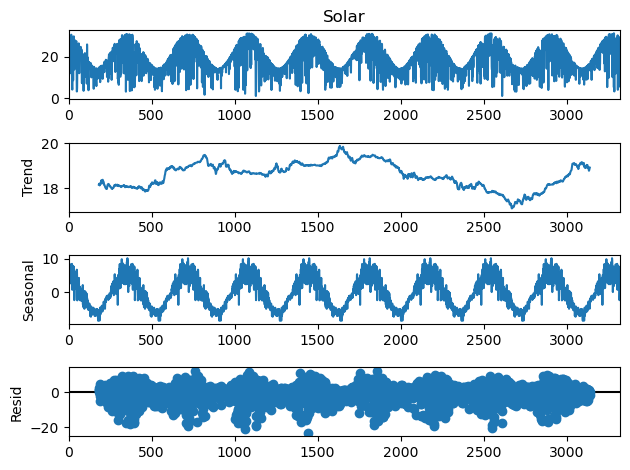

In [258]:
_ = tsa_df.plot()

As we might expect, the presence of major dips in the curve make Time Series Analysis doubtful.  The Residual 'errors' are large, and exhibit a clear periodic effect, maybe indiating that the analysis did not capture all the seasonal affect.

There is another time series analysis module ```STL```:

    decompose a time series into three components: trend, season(al) and residual. STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components.
    
Ths gives us essentially the same result, but with a smoothed trend.

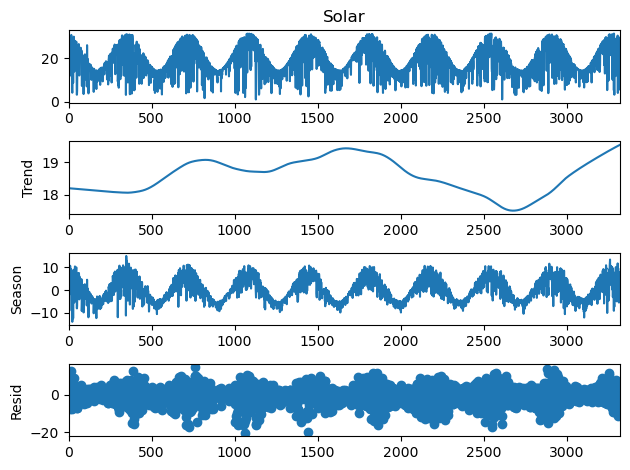

In [259]:
res = STL(
    solar.drop(columns='PDate')['Solar'],
    period=365,
).fit()
res.plot()
plt.show()

Plotting the residuals for the two approaches doesn't reveal any amjor improvement in one over the other.

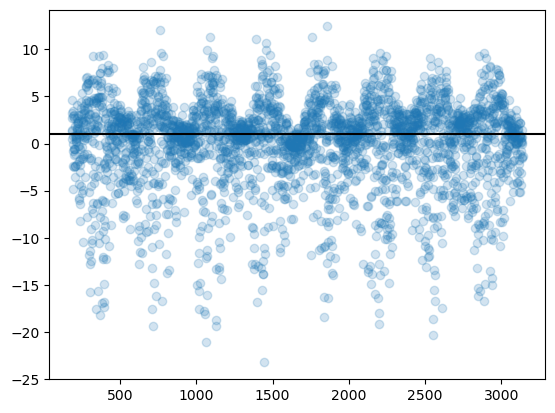

In [260]:
tsa_df.resid.plot(
    kind='line',
    linewidth=0,
    marker='o',
    alpha=0.2,
)
plt.axhline(1.0, color='black')

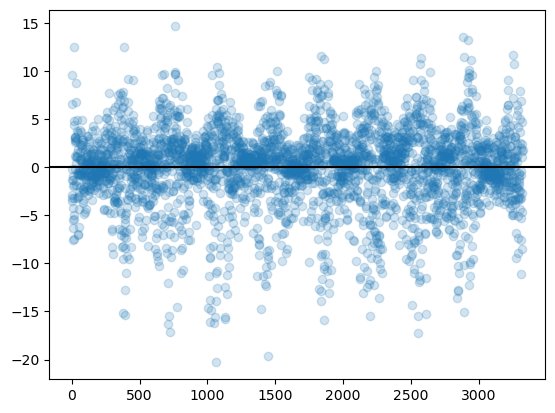

In [261]:
res.resid.plot(
    kind='line',
    linewidth=0,
    marker='o',
    alpha=0.2,
)
plt.axhline(
    0.0,
    color='black',
)

-------------------------------------
## Solar panels data load and exploration

So let's go back to our original solar energy generation from my panels. Last time, I went to some trouble to filter out the dips caused by clouds, but here I want to compare raw solar radiation data with my energy generation data.

In [262]:
def read_year_file(year: int):
    '''
    read_year_file: read the solar panel data in CSV format for the given year

    We construct a file name from the supplied year value and read the CSV data,
    skipping over row 0 (first row) as a header,
    and only using the first two columns, that first of which contains a date.
    The day number comes first (i.e. DD/MM/YYY, as opposed to MM/DD/YYYY)

    Parameters:
    year: int - the notional year of the data set to be loaded
    note - each 365 day data set spans two years, due the the way data download was
    done from the PVOutput website

    Returns:
    pandas dataframe

    Limitations:
    Does not check for file actually existing

    Does not check for successful pandas CSV read
    '''
    data_dir = pathlib.Path('../data/SolarDaily')
    file1 = 'PVOutput-COOLUMSUNSPOT-' + str(year) + '.csv'
    data_path = data_dir / file1

    df = pd.read_csv(
        data_path,
        header=0,
        usecols=[0, 1],
        parse_dates={'Date': [0]},
        dayfirst=True,
    )
    return df


# end read_year_file

Data load and visualization.

<AxesSubplot:xlabel='Date'>

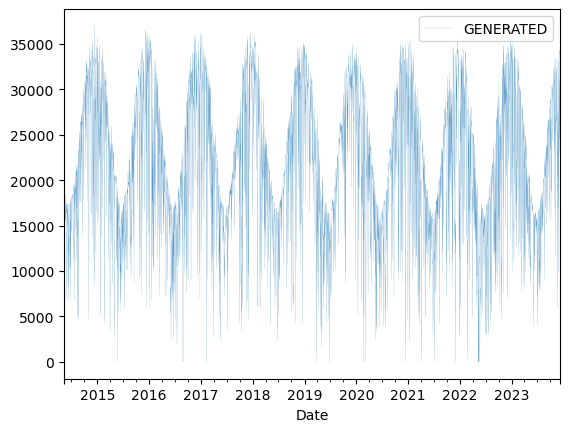

In [263]:
year_dfs = [
    read_year_file(year) for year in range(2014, 2024, 1)
]

panels = pd.concat(year_dfs)
panels.sort_values(
    'Date',
    inplace=True,
)
panels.plot(
    'Date',
    'GENERATED',
    linewidth=0.1,
)

Let's get the date range covered by my panels dataset.

In [264]:
panels.head(1), panels.tail(1)

(          Date  GENERATED
 210 2014-05-12       5599,
         Date  GENERATED
 0 2023-12-08      33279)

In [265]:
panels.dtypes

Date         datetime64[ns]
GENERATED             int64
dtype: object

-------------------

### Get matching subsets of each dataset

We create a integer index, after sorting the 'Date' values.

In [266]:
panels.sort_values(by='Date', inplace=True)
panels = panels.reset_index().drop(columns=['index'])
panels.head()

,Date,GENERATED
0,2014-05-12,5599
1,2014-05-13,12657
2,2014-05-14,17023
3,2014-05-15,16502
4,2014-05-16,11275


In [267]:
panels.tail()

,Date,GENERATED
3493,2023-12-04,24544
3494,2023-12-05,34286
3495,2023-12-06,34220
3496,2023-12-07,33808
3497,2023-12-08,33279


Now get the date range covered by my solar panel data.

In [268]:
start_date = panels['Date'].min()

In [269]:
start_date

Timestamp('2014-05-12 00:00:00')

In [270]:
end_date = panels['Date'].max()

In [271]:
end_date

Timestamp('2023-12-08 00:00:00')

---------------------
Now we create an integer index for the Solar Radiation dataframe, sorted by date.

In [272]:
solar.sort_values(
    by='PDate',
    inplace=True,
)
solar.reset_index().drop(columns=['index'])

,PDate,Solar
0,2015-01-01,28.5
1,2015-01-02,22.6
2,2015-01-03,10.7
3,2015-01-04,29.9
4,2015-01-05,18.7
...,...,...
3318,2024-02-01,20.7
3319,2024-02-02,29.4
3320,2024-02-03,29.1
3321,2024-02-04,23.4


Now get the Solar Radiation row that matches the date of my last Panel dataframe

In [273]:
solar[solar['PDate'] == pd.Timestamp('2023-12-08 00:00:00')]

,PDate,Solar
3263,2023-12-08,29.8


Now get the row from the Panels daraframe that matches the first Solar Radiation dataframe

In [274]:
panels[
    panels['Date'] == pd.Timestamp('2015-01-01 00:00:00')
]

,Date,GENERATED
234,2015-01-01,34445


------------------
Check that the two truncated dataframe align.

In [275]:
panels.iloc[
    234:,
].head(1)

,Date,GENERATED
234,2015-01-01,34445


In [276]:
panels.iloc[
    234:,
].tail(1)

,Date,GENERATED
3497,2023-12-08,33279


In [277]:
solar.iloc[
    :3264,
].tail(1)

,PDate,Solar
3263,2023-12-08,29.8


In [278]:
solar.iloc[0:].head(1)

,PDate,Solar
0,2015-01-01,28.5


Check that the shapes are the same

In [279]:
solar.iloc[0:3264].shape

(3264, 2)

In [280]:
panels.iloc[
    234:,
].shape

(3264, 2)

-----------------------------------
## Visualize two datasets

We plot the Solar Radiation for each day, against the Panel energy generation.

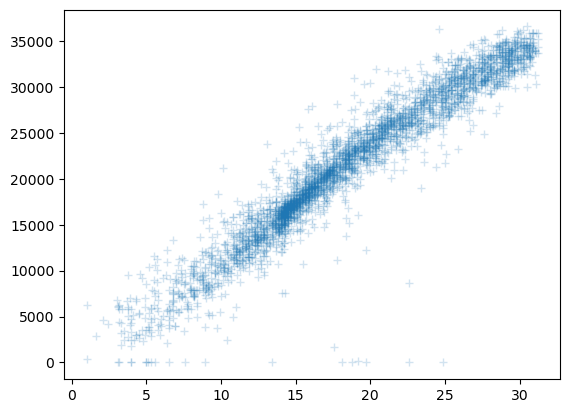

In [281]:
plt.plot(
    solar.iloc[
        0:3264,
    ]['Solar'],
    panels.iloc[
        234:,
    ]['GENERATED'],
    marker='+',
    linewidth=0,
    alpha=0.2,
)

---------------------------
Run a linear regression.  Note that if we don't explicity turn each Series into a List, pandas will try to align the index values, which is **not** what we want.

In [282]:
sun = list(
    solar.iloc[
        0:3264,
    ]['Solar']
)

generated = list(
    panels.iloc[
        234:,
    ]['GENERATED']
)

df_dict = {'Solar': sun, 'Panel': generated}
df = pd.DataFrame(df_dict)

Perform Ordinary Least Squares

In [283]:
res3 = ols(
    'Panel ~ Solar',
    data=df,
).fit()

In [284]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Panel   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 3.574e+04
Date:                Wed, 21 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:05:11   Log-Likelihood:                -29891.
No. Observations:                3264   AIC:                         5.979e+04
Df Residuals:                    3262   BIC:                         5.980e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -141.1348    120.892     -1.167      0.243    -378.167      95.897
Solar       1162.3885      6.149    189.047      0.000    1150.333    1174.444
==============================================================================
Omnibus:                     2114.452   Durbin-Watson:                   1.371
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            95796.507
Skew:                          -2.465   Prob(JB):                         0.00
Kurtosis:                      29.078   Cond. No.                         59.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot the result.

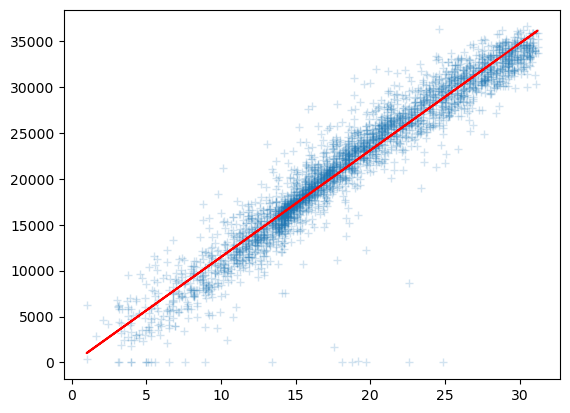

In [285]:
plt.plot(
    df['Solar'],
    df['Panel'],
    marker='+',
    linewidth=0,
    alpha=0.2,
)
plt.plot(
    df['Solar'],
    res3.predict(),
    'r-',
)

The graphics (and R^2 ) values show there is fairly good linear relationship between my panels energy generation and solar radiation.  The relationship is not perfectly linear maybe due to tempereature effects (panels are more efficent at cold temperatures), rain cleaning the panels, etc).

------------------------
## Solar radiation trend versus energy generation trends

So first we set up a date-time index on the Panel dataframe


In [286]:
panels = panels.set_index(pd.DatetimeIndex(panels['Date']))

The we get the smoothed trend line for Panel energy generation

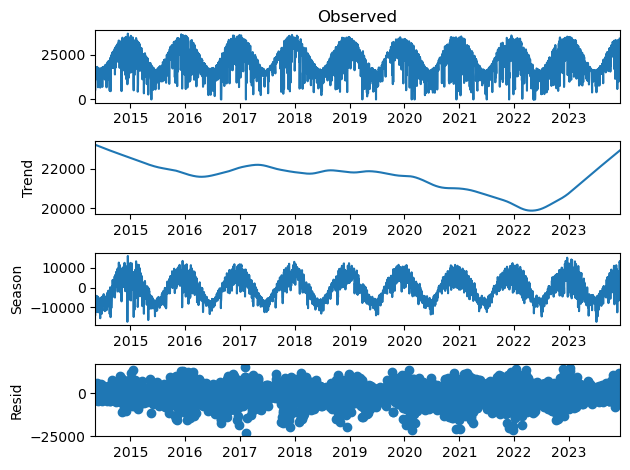

In [287]:
res2 = STL(
    panels.drop(columns='Date'),
    period=365,
).fit()
res2.plot()
plt.show()

Now we plot the trend from solar radiation, and panel enegry generation, using left and right Y axis on the same graph.  We first 
set a date-time index on the Solar radiation dataframe, so ```STL``` will associate a date-time with the trend values.

In [288]:
solar = solar.set_index(pd.DatetimeIndex(solar['PDate']))

res = STL(
    solar.drop(columns='PDate')['Solar'],
    period=365,
).fit()

Do the plotting

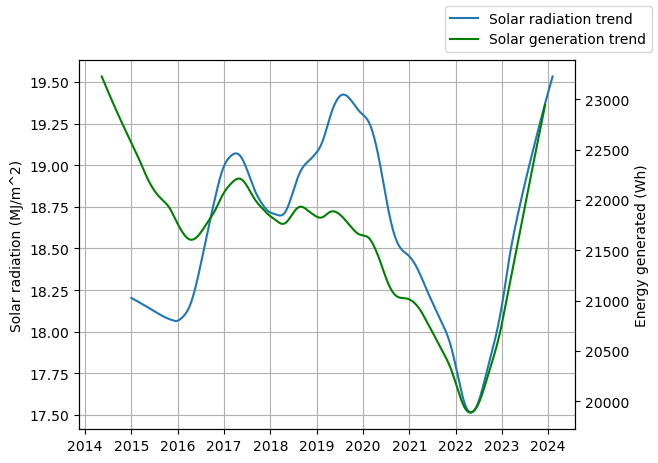

In [289]:
fig, ax1 = plt.subplots()

ax1.plot(
    res.trend.index,
    res.trend.values,
    label='Solar radiation trend',
)


ax2 = ax1.twinx()

ax2.plot(
    res2.trend.index,
    res2.trend.values,
    label='Solar generation trend',
    color='green',
)

ax1.grid(
    visible=True,
    which='both',
    axis='both',
)

ax1.set_ylabel('Solar radiation (MJ/m^2)')
ax2.set_ylabel('Energy generated (Wh)')

fig.legend()

## Conclusions
I am actually surprised that the trend lines for these  two datasets match as well as they do, especially since 2021.  

I am sceptical about the trend lines produced by the ```TSA``` call, as they are missing error bars, that might give some idea as the true confidence interval for the lines.

Note that both dataframe are heavily 'polluted' by cloudy days that generate low values essentially at random. Whether the seasonal decomposition algorithms can handle this is beyond my expertise.

Still it is food for thought:  why is solar radiation trending up?  Maybe my panel performance changes are to with solar radiation changes?

----------------------
## Reproducibility

In [290]:
%watermark

Last updated: 2024-02-21T18:05:18.572690+10:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [291]:
%watermark -co

conda environment: base



In [292]:
%watermark -iv

pandas    : 1.4.4
pathlib   : 1.0.1
matplotlib: 3.5.2

